# Introduction

The famous annual “March Madness” college basketball tournament has become one of sports' most spectacular events, earning its nickname over the decades from the unlikely heroes that have emerged to defeat giants and defy all odds. It is an annual tradition for sports fans across the states to fill out their "March Madness" tournament brackets, which means making a selection for every game in advance to try and predict who will be the winner of every game. Many competitions have sprung up around these tournament brackets, with Warren Buffet (and many others at this point) going as far as to offer \$1M to anyone who produces a completely perfect bracket. Of course, like most of Buffet's gambles, this is a completely safe one. There are more than 9 quintillion bracket combinations, so the odds of someone picking the correct one are quite far. In 2019, a tournament picker correctly selected the first 49 games of the tournament, the best on the relatively short record compiled by the NCAA (most data is only from 2015 and onwards). Using data obtained during the regular season leading up to the March Madness tournament as well as past tournament results, we should be able to predict which bracket outcomes are the most likely.

Before March Madness begins, all 350+ Division I basketball teams play a full regular season of about 30 games, beginning in the fall and continuing into early March. The final standings from the regular season will determine which teams play in the tournament. 68 teams are selected and split into 4 regions and given a seeding from 1 to 16 where 1 is the strongest and 16 is the weakest; as such, 1 is considered the "highest" seed while 16 is considered the "lowest" seed. Since there are 68 teams rather than 64, there are 4 play-in games between equally seeded opponents that occur before the first round. Frequently these play in games are between two 16 seeded teams, and play in games are always between teams of seed 11 or greater. Regardless of the play-in game outcomes, the teams of each region are paired together such that the sum of their seedings always equals 17, i.e. 1 pairs with 16, 2 pairs with 15, and so on until 8 pairs with 9. In play-in circumstances, since the play-in teams have equal seeding, the first round game will still add to 17.

As an example, lets take a look at the starting bracket from 2019. 

![Entire Bracket](2019MarchMadnessBracket.jpg)

The bracket is large so I have broken it down into 5 different pieces below:

![East](2019EastBracket.jpg)

The East bracket of the 2019 NCAA tournament.

![West](2019WestBracket.jpg)

The West bracket of the 2019 NCAA tournament.

![South](2019SouthBracket.jpg)

The South bracket of the 2019 NCAA tournament.

![Midwest](2019MidwestBracket.jpg)

The Midwest bracket of the 2019 NCAA tournament.

![Title and FirstFour](2019MiddleBracket.jpg)

The First Four, Final Four, and Championship bracket of the 2019 NCAA tournament.

The First Four games occur just prior to the tournament's first round, and are unique in that they are always teams of equal seeding. The only time that teams of equal seeding can ever play each other is during the first four and the final four games of the tournament. Another observation is that due to the bracket's arrangement any team in the bracket can play any other team at some point in the tournament. This means we will need to be able to create a prediction between any two teams in the tournament since every matchup is therotically possible.

# Problem Statement

Using the data obtained during the regular season, what are the best strategies for predicting the outcomes of the games? How well can we predict them? We will be comparing different features and using different models to make the predictions. 

Since the 2020 March Madness tournament never happened what were the theoretically most likely outcomes of the tournament? Using the model we create we can simulate the tournament and see what it might have looked like.

# Starting Simple

Usually its a good idea to start simple. One of the most basic models that we can build would be based entirely on the team's given seedings in the tournament. Seedings contain a ton of information because they are based on a very complex set of factors; team performance (wins-loss record), expert opinion, and national rankings. In fact, no 16 seed had managed to win a single tournament game against a 1 seed until 2018, almost 80 years since the tournament began. We should be able to get a model to perform well with just this information.

## Loading Data

First, we need to get some data and load it. This data was sourced from Kaggle.com.

In [1]:
#Import Modules
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import log_loss
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.inspection import permutation_importance 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

np.random.seed(31415)

output_file_name = 'NCAA_Tourney_2020'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
#Load Data
data_frames = {}
for dirname, _, filenames in os.walk('Data\MDataFiles_Stage2\.'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        data_frames[filename[:-4]] = pd.read_csv(os.path.join(dirname, filename),encoding = 'ISO-8859-1')

In [3]:
#Get a list of all of the data files we have in the dataset.
data_frames.keys()

dict_keys(['Cities', 'Conferences', 'MConferenceTourneyGames', 'MGameCities', 'MMasseyOrdinals', 'MNCAATourneyCompactResults', 'MNCAATourneyDetailedResults', 'MNCAATourneySeedRoundSlots', 'MNCAATourneySeeds', 'MNCAATourneySlots', 'MRegularSeasonCompactResults', 'MRegularSeasonDetailedResults', 'MSampleSubmissionStage2', 'MSeasons', 'MSecondaryTourneyCompactResults', 'MSecondaryTourneyTeams', 'MTeamCoaches', 'MTeamConferences', 'MTeams', 'MTeamSpellings'])

## Loading Seed Data

First we will need to load the tournament seeds. We have them in the file called 'MNCAATourneySeeds' that we just loaded. The file contains the seed stored with a distinct prefix which represents which of the four regions the team is seeded into; W, X, Y, or Z. 

In [4]:
TourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'].copy())
TourneySeeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2349,2021,Z12,1457
2350,2021,Z13,1317
2351,2021,Z14,1159
2352,2021,Z15,1331


In [64]:
TourneySeeds['Season'].unique()

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2021], dtype=int64)

We can see that the seeds are loaded as 'A##' where A represents a letter (W,X,Y, or Z) which represents one of the 4 regions, and the ## represents that teams seeding in that region. We don't need to know the region so we can strip out the team seeding with the following code.

In [5]:
TourneySeeds['SeedN'] = TourneySeeds['Seed'].apply(lambda x: int(x[1:3]))
TourneySeeds.drop('Seed',axis=1,inplace=True)
TourneySeeds.head()

,Season,TeamID,SeedN
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [6]:
TourneyResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())

## Build a Training Dataset

This is all the data we need for the first model. Next, we need a dataset to train the model. The dataframe called 'MNCAATourneyCompactResults' includes one row for every game played in the NCAA tournament from 1985 to 2019. We can use this to build an appropriate training dataset. We will organize our forecasts with the following ID: Season_Team1ID_Team2ID where Team1ID < Team2ID to eliminate duplicates. The following code creates this training dataset.

In [7]:
TourneyCompactResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())
TourneyCompactResults['TeamID1'] = np.minimum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['TeamID2'] = np.maximum(TourneyCompactResults['WTeamID'],TourneyCompactResults['LTeamID'])
TourneyCompactResults['result'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1'],1,0)
TourneyCompactResults['result_differential'] = np.where(TourneyCompactResults['WTeamID']==TourneyCompactResults['TeamID1']
                                                        ,TourneyCompactResults['WScore'] - TourneyCompactResults['LScore']
                                                        ,TourneyCompactResults['LScore'] - TourneyCompactResults['WScore'])
TourneyCompactResults['ID'] = TourneyCompactResults['Season'].astype(str)+ '_' +TourneyCompactResults['TeamID1'].astype(str)+ '_' +TourneyCompactResults['TeamID2'].astype(str)
TourneyCompactResults_Seed = TourneyCompactResults.loc[:, ['ID', 'Season', 'TeamID1', 'TeamID2', 'result']]
TourneyCompactResults_Seed.head()

,ID,Season,TeamID1,TeamID2,result
0,1985_1116_1234,1985,1116,1234,1
1,1985_1120_1345,1985,1120,1345,1
2,1985_1207_1250,1985,1207,1250,1
3,1985_1229_1425,1985,1229,1425,1
4,1985_1242_1325,1985,1242,1325,1


The variable "result" is our target variable. The variable itself is binary and represents a win for Team 1; result is 1 when team 1 is the winner of the game and 0 when team 1 is the loser of the game.

In [8]:
TourneyCompactResults_Seed = (TourneyCompactResults_Seed
                             .merge(TourneySeeds,left_on=['Season','TeamID1']
                                    ,right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team1'},axis=1)
                             .merge(TourneySeeds,left_on=['Season','TeamID2']
                                    ,right_on=['Season','TeamID'],how='left')
                             .drop('TeamID',axis=1)
                             .rename({'SeedN':'Seed_Team2'},axis=1)
                             )

TourneyCompactResults_Seed['Seed_Differential'] = TourneyCompactResults_Seed['Seed_Team1'] - TourneyCompactResults_Seed['Seed_Team2'] 
# TourneyCompactResults_Seed['Seed_Differential_Norm'] = (TourneyCompactResults_Seed['SeedN_x'] - TourneyCompactResults_Seed['SeedN_y']) / np.sqrt(np.minimum(TourneyCompactResults_Seed['SeedN_x'], TourneyCompactResults_Seed['SeedN_y']))

TourneyCompactResults_Seed.head()

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential
0,1985_1116_1234,1985,1116,1234,1,9,8,1
1,1985_1120_1345,1985,1120,1345,1,11,6,5
2,1985_1207_1250,1985,1207,1250,1,1,16,-15
3,1985_1229_1425,1985,1229,1425,1,9,8,1
4,1985_1242_1325,1985,1242,1325,1,3,14,-11


In the end it would be nice to have a final testing dataset to see how the models perform in the closest conditions they could be to normal. Therefore, I removed the 2019 season entirely so we can use it for final testing.

In [14]:
TourneyCompactResults_Seed = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 1985][TourneyCompactResults_Seed['Season'] <= 2021]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 1985][TourneyCompactResults_Seed['Season'] <= 2017]
TourneyCompactResults_Seed_Test = TourneyCompactResults_Seed[TourneyCompactResults_Seed['Season'] >= 2018][TourneyCompactResults_Seed['Season'] <= 2021]
TourneyCompactResults_Seed_Train = TourneyCompactResults_Seed_Train.fillna(0)

In [15]:
feature_list_seed = ['Seed_Team1', 'Seed_Differential']

In [16]:
explore_df_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed + ['Season', 'result']]
explore_df_seed.head()

,Seed_Team1,Seed_Differential,Season,result
0,9,1,1985,1
1,11,5,1985,1
2,1,-15,1985,1
3,9,1,1985,1
4,3,-11,1985,1


## Ploting variable interactions

Before we create a model, lets take a visual look at our two features and how they interact with result, our target variable. First, since we only have two features we can plot them individually and use a kernal density estimation to visually see the estimated density.


This will give us a matrix of scatterplots for every variable interaction and a KDE along the diagonal. 

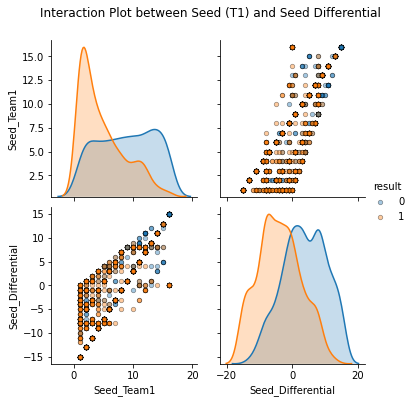

In [17]:
plot = sns.pairplot(explore_df_seed, hue="result", vars=feature_list_seed, plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})

plot.fig.suptitle("Interaction Plot between Seed (T1) and Seed Differential", y=1.08)
plt.show()

## Splitting into training/testing and scaling.

Unfortunately, there is a lot of variance in the model outputs introduced based on the train/test split. To help eliminate this problem, we will need to use kfold validation to view the model accuracy across as an average across all of the data. We will set aside 30% of our data for testing and stratify on season. This will ensure we recieve a fairly even distribution of each season in both the training and testing datasets. We also normalize the dataset to help with convergence.

In [18]:
x_seed = TourneyCompactResults_Seed_Train.loc[:, feature_list_seed]
xs_seed = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x_seed), columns = x_seed.columns)
y_seed = TourneyCompactResults_Seed_Train[['result']]
x_train_seed, x_test_seed, y_train_seed, y_test_seed = train_test_split(xs_seed, y_seed, test_size=0.3, stratify = TourneyCompactResults_Seed_Train['Season'])

## Building a Model - Logistic Regression

One of the simplest models for this sort of classification is logistic regression. Logistic regression uses the logistic function to model the probability of a binary event. The logistic function is defined as follows

\begin{equation*}
\sigma (t) = \frac{1}{1+e^{-t}}
\end{equation*}

By defining $t = \beta_0 + \beta_1x_1 + \beta_2x_2$, we can rewrite:

\begin{equation*}
p(X) = \sigma (t) = \frac{1}{1+e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2)}}
\end{equation*}

Consequently, the logit function can be defined as:

\begin{equation*}
\frac{p(X)}{1-p(X)} = e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2)}
\end{equation*}

To get started, first we will hypertune for the $\alpha$ parameter. We want to see the minimum log loss produced as that is the scoring method we would like to use. Log loss, $L(x,p)$, is calculated as follows for a binary event $x_i$ and event probability $p_i$:
\begin{equation*}
L(x_i, p_i) =
 \begin{cases} 
      -\log(p_i) & x_i = 0 \\
      -\log(1-p_i) & x_i = 1
   \end{cases}
\end{equation*}
We will run the regression multiple times and test $\alpha$ at different levels to see what works best. We will also perform 5 fold cross validation to make sure we are not overfitting.

In [19]:
feature_list_seed = ['Seed_Team1', 'Seed_Differential']
for alpha in [0.001,0.01,0.1,1,10, 100, 1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.618298315805764
0.01 -0.5543780794125246
0.1 -0.5425505602952573
1 -0.5420295292551375
10 -0.5420388388729822
100 -0.5420406995107008
1000 -0.5420408953197617


We note that $\alpha=1$ seems to work well for this model. Now we can create a logistic regression model using $\alpha=C=1$

In [20]:
lr = LogisticRegression(solver='lbfgs',C=1,random_state=42,max_iter=500, fit_intercept=False)
model = lr.fit(x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel())
ypred = model.predict_proba(x_test_seed.loc[:, feature_list_seed])
score = log_loss(y_test_seed, ypred[:,1])
score

0.5781111450640767

Based on the KDE in the pairplot above, seed and seed differential look to be highly correlated with each other. We may capture all the information we need in seed differential alone, so lets try a model using only the seed differential as I expect that to be the more predictive factor than just seed. I think this because seed says nothing about the opponent, so if two 1 seeds are playing each other our forecast would be significantly biased and produce a much higher probability than reality.

In [21]:
feature_list_seed = ['Seed_Differential']

In [22]:
for alpha in [0.001,0.01,0.1,1,10, 100, 1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))
    # 0.5538911848914796

0.001 -0.6379007067190035
0.01 -0.5575442176769745
0.1 -0.5420736009790807
1 -0.5417021952970196
10 -0.5417049439853094
100 -0.5417056981036404
1000 -0.5417057784033457


Again, we note that $\alpha=1$ seems to work well for this model. We can now create another logistic regression model using $\alpha=C=1$

In [23]:
lr = LogisticRegression(solver='lbfgs',C=1,random_state=42,max_iter=500, fit_intercept=False)
model = lr.fit(x_train_seed.loc[:, feature_list_seed], y_train_seed.values.ravel())
ypred = model.predict_proba(x_test_seed.loc[:, feature_list_seed])
score = log_loss(y_test_seed, ypred[:,1])
score

0.5795559176005709

Both models performed similarly, but we actually gain a very small amount of accuracy after removing the seed of team 1 from our features. Both of these models should work well enough to give us a baseline model to build on.

# Adding More Features

We want to add some more features to help the prediction power of our model. There are several features we want to focus on adding first.

## Points and Point Margins

Points are the essence of basketball and are the basis for how the game is scored. We should be able to understand a lot about how each team might perform by understanding how many points they usually score and how many points they usually allow, which is how many points the team lets their opponents score. 

* Offensive Point Margin (OPM) - How many more or less points the given team is expected to score over a particular opponent's average points allowed.

    * Example: Team A has an OPM of +10. When playing team B that normally allows their opponent to score 60 points, we would expect team A to score 70 points. 


* Defensive Point Margin (DPM) - How many more or less points the opponent is expected to score when playing the given team than average.

    * Example: Team A has a DPM of -10. When playing team B that normally scores 70 points, we would expect team B to score 60 points. 
    

* Total Point Margin (TPM) - Total Point Margin is just OPM + DPM for the given team. This combines the teams offensive and defensive strength to produce an overall strength.



## Past Tournament Results

For better or for worse, some teams are simply a ficture of the NCAA tournament. Teams like Duke, Kansas, Kentucky, and more tend to consistently do well regardless of their tournament seeding. For example, in 2014 Kentucky made it to the championship game as an 8 seed - one of the lowest seeded teams to ever reach the championship. Coincidentally, they played against a 7th seeded UConn in that championship game, another one of the lowest seeds to ever reach the championship. This example is very interesting as both teams historically do well in the tournament; in fact, UConn won the 2011 tournament and Kentucky won the 2012 tournament, but neither team actually made it into the 2013 tournament at all. This is strong anecdotal evidence to use at least a 4 year history of tournament results to predict how well different teams may do.

## Recency

Sometimes, teams simply get better or worse over the course of a season. Therefore its important to understand how every team was doing near the end of the season since their performance during this time should be most indicitave of their tournament performance. We can capture this information by looking at TPM for games played over the last month or so of the season. We will include games on or after day 100 of the season for our recency feature.

## Advanced Statistics

A lot of research has already been done to determine the strength of basketball teams. A colleague suggested looking into the idea of the "Four Factors"; a term coined to refer to 4 major statistics that are helpful to determine the overall strength of a team. The idea was adapted from here: https://www.basketball-reference.com/about/factors.html 

The 4 factors are:

* Shooting - A teams ability to put the basketball in their opponent's hoop, scoring them points.

* Rebounding - A teams ability to grab a missed shot to get possession of the ball, allowing them to score more points.

* Turnovers - A teams ability to not turnover the ball & their ability to steal or otherwise obtain the ball from their opponent, allowing them to score more points.

* Free Throws - A teams ability to both get to the free throw line frequently and also make those free throw shots, thus scoring more points.

If you are familiar with basketball then these factors will make a lot of sense to you as they define most of the important elements of the game. They all have a common theme in allowing the team to score more points but rebounding and turnovers are really about ball possession. Additionally, free throws are a somewhat indirect factor as free throws may only be attempted when a team is fouled. Therefore it is possible for a team to do poorly in this factor due to simply not shooting many free throws, which may be a problem later down the line in our analysis with this factor. It is included in our initial analysis due to its inclusion in the aforementioned "four factors" and from an anecdotal point of view as many teams truly do find ways to win with free throws in the late game. We may adjust this factor later to look at free throw percentage in the late game since I believe this is truly what counts when it comes to free throws.

## Adding More Data

Before we can start adding any new features to try to improve the model, we will need to some work with the MRegularSeasonDetailedResults file that we have. The data includes one row for every regular season game from 2003 to 2020, and denotes the teams involved in the game by the winning team ID and losing team ID. We need to transform the data so we can start looking at season averages for a single team which means we need to create a dataset where each team has one record for every game it played. The easiest way to do this will be to create the final dataset from two simple datasets. First will create a dataset of every team's wins and label the columns accordingly. We set Win = 1 and Loss = 0.

In [24]:
winning_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

winning_dataset = winning_dataset[['Season', 'DayNum'
                                   , 'WTeamID', 'WScore', 'WLoc', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'
                                   , 'LTeamID', 'LScore', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]
winning_dataset.columns = ['Season', 'DayNum'
                           , 'TeamID', 'Score', 'Loc','NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                           , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

winning_dataset['Win'] = 1
winning_dataset['Loss'] = 0

Next, we will do the same thing for every team's losses. WLoc needs to be flipped to be from the losing teams perspective, meaning that when WLoc = 'A' we set it to be 'H' and when WLoc = 'H' we set it to be 'A'. Also, we pull the losing stats instead of the winning stats into the team's statistics and pull the winning stats into the opponent's statistics and set Win = 0 and Loss = 1.

In [25]:
losing_dataset = pd.DataFrame(data_frames['MRegularSeasonDetailedResults'].copy())

losing_dataset.loc[losing_dataset['WLoc'] == 'H', 'Loc'] = 'A'
losing_dataset.loc[losing_dataset['WLoc'] == 'N', 'Loc'] = 'N'
losing_dataset.loc[losing_dataset['WLoc'] == 'A', 'Loc'] = 'H'

losing_dataset = losing_dataset[['Season', 'DayNum'
                                 , 'LTeamID', 'LScore', 'Loc','NumOT', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'
                                 , 'WTeamID', 'WScore', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]
losing_dataset.columns = ['Season', 'DayNum'
                          , 'TeamID', 'Score', 'Loc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'
                          , 'OTeamID', 'OScore', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF']

losing_dataset['Win'] = 0
losing_dataset['Loss'] = 1

Now we can join the datasets together and every team will have one row for every win and one row for every loss which is one row for every game played since ties can not happen.

In [26]:
AllSeasonResults = pd.concat([winning_dataset, losing_dataset], ignore_index=True)
AllSeasonResults.head()

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OTeamID,OScore,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,Win,Loss
0,2003,10,1104,68,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,1328,62,22,53,2,10,16,22,10,22,8,18,9,2,20,1,0
1,2003,10,1272,70,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,1393,63,24,67,6,24,9,20,20,25,7,12,8,6,16,1,0
2,2003,11,1266,73,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,1437,61,22,73,3,26,14,23,31,22,9,12,2,5,23,1,0
3,2003,11,1296,56,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,1457,50,18,49,6,22,8,15,17,20,9,19,4,3,23,1,0
4,2003,11,1400,77,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,1208,71,24,62,6,16,17,27,21,15,12,10,7,1,14,1,0


Finally, we can calculate season averages by team. This data includes regular season games only and will be available prior to any games played in the NCAA tournament.

In [27]:
seasonGroups = (AllSeasonResults
               .groupby(['Season','TeamID'])
               )
                
    

seasonAve = (seasonGroups[['Score','OScore','Win', 'FGM', 'FGA', 'FGM3', 'FGA3','FTM', 'FTA', 'OR', 'DR', 'Ast', 'Stl', 'Blk','TO', 'PF', 'OFGM', 'OFGA', 'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OBlk', 'OPF','OTO']]
             .mean()
             .rename({'Win':'WinPCT'},axis=1)
             .reset_index()
             )
seasonAve.round(1).tail()

,Season,TeamID,Score,OScore,WinPCT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,Stl,Blk,TO,PF,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OBlk,OPF,OTO
6529,2021,1467,66.3,66.7,0.5,24.1,53.7,7.0,22.1,11.1,16.7,5.8,22.1,12.0,8.0,3.8,13.0,7.7,23.6,55.9,6.4,18.7,13.0,18.4,9.2,25.2,2.3,7.6,14.4
6530,2021,1468,72.6,68.3,0.6,27.3,54.5,6.3,17.1,11.7,15.5,6.7,19.8,15.2,6.6,2.1,10.8,2.7,23.8,51.8,10.1,25.6,10.5,14.6,7.4,20.8,2.8,2.9,15.1
6531,2021,1469,67.6,78.2,0.3,23.4,57.8,5.8,19.7,15.1,20.5,7.7,23.2,14.4,6.7,2.1,15.3,4.3,28.1,61.0,7.2,22.2,14.8,22.3,10.4,27.6,3.9,3.8,13.7
6532,2021,1470,63.9,68.1,0.3,22.0,50.9,5.5,14.6,14.4,19.4,4.4,20.1,11.3,6.7,2.3,10.9,6.7,21.5,49.7,8.7,24.1,16.3,22.6,9.1,24.6,4.3,7.4,14.7
6533,2021,1471,68.6,76.6,0.3,25.7,55.9,10.1,27.4,7.1,11.6,4.5,20.9,16.5,5.7,1.7,13.5,6.2,29.4,61.0,7.8,20.5,10.1,13.6,9.1,26.4,2.6,6.1,12.5


## Calculating Point Margin Features

First, we will create a copy of the AllSeasonResults dataset that we created earlier and filter down to just the data we need, which is just Score and OScore. We also include DayNum so we can later calculate a recency statistic as well. 

In [32]:
AllSeasonResults_copy = AllSeasonResults.copy()

Season_Data = AllSeasonResults_copy.loc[:,['Season', 'TeamID','OTeamID', 'Score', 'OScore', 'DayNum']]
seasonAve_small = seasonAve.loc[:, ['Season', 'TeamID', 'Score', 'OScore']].rename({'Score':'Season_Avg_Points'},axis=1).rename({'OScore':'Season_Avg_Pnts_Against'},axis=1)
Season_Data = (Season_Data
               .merge(seasonAve_small, on=['Season','TeamID'], how='left')
               .rename({'Season_Avg_Points':'Pts_For'},axis=1)
               .rename({'Season_Avg_Pnts_Against':'Pts_Against'},axis=1)
               .merge(seasonAve_small, left_on=['Season','OTeamID'], right_on=['Season','TeamID'], how='left')
               .rename({'Season_Avg_Points':'OPts_For'},axis=1)
               .rename({'Season_Avg_Pnts_Against':'OPts_Against'},axis=1)
               .drop('TeamID_y',axis=1)
               .rename({'TeamID_x':'TeamID'},axis=1))
Season_Data.round(1).head()

,Season,TeamID,OTeamID,Score,OScore,DayNum,Pts_For,Pts_Against,OPts_For,OPts_Against
0,2003,1104,1328,68,62,10,69.3,65.0,71.2,60.2
1,2003,1272,1393,70,63,10,74.5,65.8,80.1,69.9
2,2003,1266,1437,73,61,11,78.4,67.7,72.2,70.1
3,2003,1296,1457,56,50,11,69.6,69.8,69.4,66.4
4,2003,1400,1208,77,71,11,78.9,68.7,79.2,73.2


### Offensive Point Margin

Offensive point margin $O(j)$ is the number of points scored by team $j$ minus the opponents season average points allowed. Let $x_{i,j}$ be the points scored by team $i$ in game $j$ and $\bar{A}_{i,j}$ be the average points allowed by the opponent played by team $i$ in game $j$. Let there be $n$ games in the season for team $j$. Then, the season average offensive point margin is defined as:

\begin{equation*}
O(j) = \frac{1}{n}\sum_{j=1}^{n}{(x_{i,j} -  \bar{A}_{i,j})}
\end{equation*}

Not only does this equation help us understand how many points a team usually scores, it also adjusts it against how difficult it to score points against the given team due to the $\bar{A}_{i,j}$ term. This adjustment helps account the strength of a team's schedule, which is a measurement of the quality of the team's opponents.

In [33]:
Season_Data['Offensive_Margin'] = Season_Data['Score'] - Season_Data['OPts_Against']

### Defensive Point Margin

Similarly, the defensive point margine $D(j)$ is the average points allowed by team $j$ minus the opponents season average points scored. Let $x_{i,j}$ be the points allowed by team $i$ in game $j$ and $\bar{S}_{i,j}$ be the average points scored by the opponent played by team $i$ in game $j$. Let there be $n$ games in the season for team $j$. Then, the season average defensive point margin is defined as:

\begin{equation*}
D(j) = -\frac{1}{n}\sum_{j=1}^{n}{(x_{i,j} -  \bar{S}_{i,j})}
\end{equation*}

Similar to the calculation for Offensive Point Margin, we are accounting for the team's strength of schedule with the $\bar{S}_{i,j}$ term.

In [34]:
Season_Data['Defensive_Margin'] = -(Season_Data['OScore'] - Season_Data['OPts_For'])

### Total Point Margin

Total point margin $M(j)$ for team $j$ is defined as the sum of both offensive and defensive point margin. 

\begin{equation*}
M(j) = O(j) + D(j) 
\end{equation*}

In [35]:
Season_Data['Total_Margin'] = Season_Data['Offensive_Margin'] + Season_Data['Defensive_Margin']
Season_Data['Total_Margin_Recent'] = Season_Data[Season_Data['DayNum'] >= 100]['Total_Margin']
Season_Data.round(1).tail()

,Season,TeamID,OTeamID,Score,OScore,DayNum,Pts_For,Pts_Against,OPts_For,OPts_Against,Offensive_Margin,Defensive_Margin,Total_Margin,Total_Margin_Recent
193369,2021,1261,1104,79,80,132,82.1,75.3,79.6,69.8,9.2,-0.4,8.8,8.8
193370,2021,1259,1159,72,85,132,72.1,70.9,86.3,68.6,3.4,1.3,4.7,4.7
193371,2021,1153,1222,54,91,132,68.9,72.1,76.3,58.3,-4.3,-14.7,-19.0,-19.0
193372,2021,1326,1228,88,91,132,77.3,71.0,81.4,69.2,18.8,-9.6,9.2,9.2
193373,2021,1433,1382,65,74,132,71.7,65.2,70.5,60.4,4.6,-3.5,1.1,1.1


In [36]:
season_margin = (Season_Data
               .groupby(['Season','TeamID'])
               )
                
season_margin_Ave = (season_margin[['Offensive_Margin','Defensive_Margin', 'Total_Margin', 'Total_Margin_Recent']]
             .mean()
             .reset_index()
             )
season_margin_Ave['Total_Margin_Recent_Change'] = season_margin_Ave['Total_Margin_Recent'] - season_margin_Ave['Total_Margin']

season_margin_Ave.round(1).tail()

,Season,TeamID,Offensive_Margin,Defensive_Margin,Total_Margin,Total_Margin_Recent,Total_Margin_Recent_Change
6529,2021,1467,-7.3,5.6,-1.7,-0.2,1.5
6530,2021,1468,0.8,0.7,1.5,1.9,0.4
6531,2021,1469,-3.3,-7.2,-10.4,-6.6,3.8
6532,2021,1470,-6.3,2.9,-3.4,-1.5,1.9
6533,2021,1471,1.2,-5.7,-4.5,-3.8,0.7


We now have a table that has all of the point margin features for every team and every season. 

In [37]:
TourneyResults = pd.DataFrame(data_frames['MNCAATourneyCompactResults'].copy())

round_64_winners = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] <= 137][TourneyResults['DayNum'] >= 136]
round_64_winners['Round_Win_Weighting'] = 1
round_32_winners = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] <= 139][TourneyResults['DayNum'] >= 138]
round_32_winners['Round_Win_Weighting'] = 1
sweet_sixteen_winners = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] <= 144][TourneyResults['DayNum'] >= 143]
sweet_sixteen_winners['Round_Win_Weighting'] = 2
elite_eight_winners = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] <= 146][TourneyResults['DayNum'] >= 145]
elite_eight_winners['Round_Win_Weighting'] = 4
final_four_winners = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] == 152]
final_four_winners['Round_Win_Weighting'] = 8
winning_teams = TourneyResults.loc[:,['WTeamID', 'Season']][TourneyResults['DayNum'] == 154]
winning_teams['Round_Win_Weighting'] = 16

historical_round_win_weight = pd.concat([round_64_winners, round_32_winners, sweet_sixteen_winners, elite_eight_winners, final_four_winners, winning_teams], ignore_index=True)
historical_tourney_performance = historical_round_win_weight.groupby(['WTeamID', 'Season']).sum().unstack('WTeamID').fillna(0).rolling(4).sum().stack('WTeamID').reset_index()
historical_tourney_performance['Season'] = historical_tourney_performance['Season'] + 1
historical_tourney_performance # [historical_tourney_performance['WTeamID'] == 1112]

,Season,WTeamID,Round_Win_Weighting
0,1989,1104,6.0
1,1989,1112,8.0
2,1989,1113,0.0
3,1989,1114,1.0
4,1989,1116,1.0
...,...,...,...
5819,2020,1458,4.0
5820,2020,1459,1.0
5821,2020,1461,0.0
5822,2020,1462,6.0


## Calculating Advanced Statistics


### Shooting: True Shooting Percentage (TS%), Defensive TS% (DTS%), and $\Delta$TS\%

\begin{equation*}
\mbox{TS\%} = \frac{\mbox{Points Scored}}{2 (\mbox{Field Goals Attempted} + .475\mbox{ Free Throws Attempted})}
\end{equation*}

\begin{equation*}
\mbox{DTS\%} = \frac{\mbox{Opponent Points Scored}}{2 (\mbox{Opponent Field Goals Attempted} + .475\mbox{ Opponent Free Throws Attempted})}
\end{equation*}

\begin{equation*}
\Delta\mbox{ TS\%} = \mbox{TS\%} - \mbox{DTS\%}
\end{equation*}

TS% is a excellent way to measure the efficiency of a team's offense. $\mbox{Field Goals Attempted} + .475 \mbox{ Free Throws Attempted}$ is an approximate measurement of the total number of posessions that the team has. Using points as the numerator and dividing by two normalizes points to possessions while awarding more credit for 3 pointers and less credit for free throws (1 point). Similarly, DTS% is a good way to measure the efficiency of the defense. $\Delta$TS% measures how much better or worse the team does relative to their opponents with respect to TS%.

In [38]:
seasonAve['TS%'] = seasonAve['Score'] / (2 * (seasonAve['FGA'] + .475 * seasonAve['FTA']))
seasonAve['DTS%'] = seasonAve['OScore'] / (2 * (seasonAve['OFGA'] + .475 * seasonAve['OFTA']))
seasonAve['TS%Diff'] = seasonAve['TS%'] - seasonAve['DTS%']

### Rebounding: Offensive Rebounding (ORB%), Defensive Rebounding (DRB%), and $\Delta$Reb

\begin{equation*}
\mbox{ORB\%} = \frac{\mbox{Offensive Rebounds}}{\mbox{Offensive Rebounds} + \mbox{Opponent Defensive Rebounds}}
\end{equation*}

\begin{equation*}
\mbox{DRB\%} = \frac{\mbox{Defensive Rebounds}}{\mbox{Defensive Rebounds} + \mbox{Opponent Offensive Rebounds}}
\end{equation*}

\begin{equation*}
\Delta \mbox{ Reb} = \mbox{ORB\%} - (1-\mbox{DRB\%})
\end{equation*}

Rebounding is essential to basketball. An offensive rebound gives an offense another chance at points which is essentially an additional possession. In this sense, an offensive rebound is similar to a turnover. Similarly, a defensive rebound is the final piece of a successful defense. The more frequently a team secures a defensive rebound means less chances for the opponent to score. Similar to TS% we can create another differential statistic with ORB% and DRB%:


In [39]:
seasonAve['ORB%'] = seasonAve['OR'] / (seasonAve['ODR'] + seasonAve['OR'])
seasonAve['DRB%'] = seasonAve['OOR'] / (seasonAve['OOR'] + seasonAve['DR'])
seasonAve['ORB%Diff'] = seasonAve['ORB%'] - seasonAve['DRB%']

### Turnovers: Turnovers per Possession (TOV%), Defensive Turnovers per Possession (DTOV%), and $\Delta$TOV

\begin{equation*}
\mbox{TOV\%} = \frac{\mbox{Turnovers}}{\mbox{Field Goals Attempted} + .475\mbox{Free Throws Attempted} + \mbox{Turnovers}}
\end{equation*}

\begin{equation*}
\mbox{DTOV\%} = \frac{\mbox{Opponent Turnovers}}{\mbox{Opponent FG Attempted} + .475\mbox{Opponent FT Attempted} + \mbox{Opponent Turnovers}}
\end{equation*}

\begin{equation*}
\Delta \mbox{TOV} = \mbox{TOV\%} - \mbox{DTOV\%}
\end{equation*}

Turnovers are a key piece of the basketball puzzle. Turnovers are a way to steal a possession from another team; A turnover can happen when the ball goes out of bounds or one team steals the ball from another. In either case (or other turnover scenarios), one team effectively loses a possession. Over time, a teams ability to keep the ball in their hands and limit turnovers while forcing opponent turnovers will be able to have more possessions than their opponents, which should directly translate into points. We can measure the team's ability to both limit turnovers and force opponent turnovers as the differential between TOV% and DTOV%:


In [40]:
seasonAve['TOV%'] = 100 * seasonAve['TO'] / (seasonAve['FGA'] + .475 * seasonAve['FTA'] + seasonAve['TO'])
seasonAve['DTOV%'] = 100 * seasonAve['OTO'] / (seasonAve['OFGA'] + .475 * seasonAve['OFTA'] + seasonAve['OTO'])
seasonAve['TOV%Diff'] = seasonAve['TOV%'] - seasonAve['DTOV%']

### Free Throws: Free Throw Efficiency (FT/FGA), Defensive Free Throw Efficiency (DFT/FGA), and $\Delta$FT

\begin{equation*}
\frac{\mbox{FT}}{\mbox{FGA}} = \frac{\mbox{FreeThrows}}{\mbox{FieldGoalsAttempted}}
\end{equation*}

\begin{equation*}
\frac{\mbox{DFT}}{\mbox{FGA}} = \frac{\mbox{OpponentFreeThrowsAttempted}}{\mbox{OpponentFieldGoalsAttempted}}
\end{equation*}

\begin{equation*}
\Delta \mbox{ FT} = \frac{\mbox{FT}}{\mbox{FGA}} - \frac{\mbox{DFT}}{\mbox{FGA}}
\end{equation*}

At first glance these metrics may seem odd but they capture some important information about a teams efficiency to get to the foul line and make their free throws. The metric rewards teams for getting to the free throw line, making the free throw shots, or some combination of both. DFT/FGA captures the teams ability to not let their opponents get to the free throw line. $\Delta$FT captures the teams ability to capitalize on free throws while limiting their opponents. As noted earlier, some teams simply may not get fouled as much but still perform well. Since we currently can not calculate late game free throw percentage we will settle for this statistic for now.



In [41]:
seasonAve['FT/FGA'] = seasonAve['FTM'] / seasonAve['FGA']
seasonAve['DFT/FGA'] = seasonAve['OFTA'] / seasonAve['OFGA']
seasonAve['FT/FGADiff'] = seasonAve['FT/FGA'] - seasonAve['DFT/FGA']

## Preparing the Training Data

Now we just need to add all of our features back to the training dataset we worked with earlier. 

In [42]:
TourneyCompactResults = TourneyCompactResults_Seed

TourneyCompactResults = (TourneyCompactResults
                         .merge(seasonAve
                                ,left_on=['Season','TeamID1'],right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(seasonAve
                                ,left_on=['Season','TeamID2']
                                ,right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(season_margin_Ave
                                ,left_on=['Season','TeamID1']
                                ,right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(season_margin_Ave
                                ,left_on=['Season','TeamID2']
                                ,right_on=['Season','TeamID'],how='left')
                         .drop('TeamID',axis=1)
                         .merge(historical_tourney_performance
                                , left_on=['Season','TeamID1']
                                ,right_on=['Season','WTeamID'],how='left')
                         .drop('WTeamID',axis=1)
                         .merge(historical_tourney_performance
                                , left_on=['Season','TeamID2']
                                ,right_on=['Season','WTeamID'],how='left')
                         .drop('WTeamID',axis=1)
                         .fillna(0)
                        )

TourneyCompactResults.round(1).tail()

,ID,Season,TeamID1,TeamID2,result,Seed_Team1,Seed_Team2,Seed_Differential,Score_x,OScore_x,WinPCT_x,FGM_x,FGA_x,FGM3_x,FGA3_x,FTM_x,FTA_x,OR_x,DR_x,Ast_x,Stl_x,Blk_x,TO_x,PF_x,OFGM_x,OFGA_x,OFGM3_x,OFGA3_x,OFTM_x,OFTA_x,OOR_x,ODR_x,OBlk_x,OPF_x,OTO_x,TS%_x,DTS%_x,TS%Diff_x,ORB%_x,DRB%_x,ORB%Diff_x,TOV%_x,DTOV%_x,TOV%Diff_x,FT/FGA_x,DFT/FGA_x,FT/FGADiff_x,Score_y,OScore_y,WinPCT_y,FGM_y,FGA_y,FGM3_y,FGA3_y,FTM_y,FTA_y,OR_y,DR_y,Ast_y,Stl_y,Blk_y,TO_y,PF_y,OFGM_y,OFGA_y,OFGM3_y,OFGA3_y,OFTM_y,OFTA_y,OOR_y,ODR_y,OBlk_y,OPF_y,OTO_y,TS%_y,DTS%_y,TS%Diff_y,ORB%_y,DRB%_y,ORB%Diff_y,TOV%_y,DTOV%_y,TOV%Diff_y,FT/FGA_y,DFT/FGA_y,FT/FGADiff_y,Offensive_Margin_x,Defensive_Margin_x,Total_Margin_x,Total_Margin_Recent_x,Total_Margin_Recent_Change_x,Offensive_Margin_y,Defensive_Margin_y,Total_Margin_y,Total_Margin_Recent_y,Total_Margin_Recent_Change_y,Round_Win_Weighting_x,Round_Win_Weighting_y
2246,2019_1120_1246,2019,1120,1246,1,5,2,3,78.9,68.6,0.7,27.0,60.4,11.4,30.0,13.4,18.7,11.7,21.9,14.4,9.3,4.8,12.1,18.4,23.2,52.9,8.3,23.4,13.8,19.4,10.8,24.2,3.7,17.2,17.6,0.6,0.6,0.0,0.3,0.3,-0.0,14.9,22.1,-7.2,0.2,0.4,-0.1,76.7,65.4,0.8,26.6,55.6,6.0,16.6,17.5,23.6,11.6,26.8,13.8,6.0,5.1,12.6,16.3,23.3,57.8,7.8,22.2,11.1,15.7,9.3,20.1,3.0,19.6,12.5,0.6,0.5,0.1,0.4,0.3,0.1,15.9,16.1,-0.2,0.3,0.3,0.0,9.0,4.5,13.4,9.1,-4.3,5.5,9.1,14.5,13.7,-0.8,1.0,15.0
2247,2019_1181_1277,2019,1181,1277,0,1,2,-1,83.5,67.6,0.9,30.5,63.9,7.3,24.1,15.2,22.1,13.4,28.4,15.9,9.5,6.8,13.1,15.9,25.2,63.9,6.5,22.1,10.6,15.3,12.0,23.7,3.2,17.7,14.8,0.6,0.5,0.1,0.4,0.3,0.1,15.0,17.2,-2.2,0.2,0.2,-0.0,78.8,65.5,0.8,27.8,57.2,8.3,21.6,15.0,20.0,10.8,30.1,18.9,5.2,5.5,12.9,16.9,23.3,61.7,7.3,22.9,11.6,17.1,11.0,20.9,2.9,18.3,10.3,0.6,0.5,0.1,0.3,0.3,0.1,16.2,12.8,3.3,0.3,0.3,-0.0,14.9,6.1,21.0,12.0,-9.1,10.2,6.5,16.7,15.9,-0.8,39.0,10.0
2248,2019_1277_1403,2019,1277,1403,0,2,3,-1,78.8,65.5,0.8,27.8,57.2,8.3,21.6,15.0,20.0,10.8,30.1,18.9,5.2,5.5,12.9,16.9,23.3,61.7,7.3,22.9,11.6,17.1,11.0,20.9,2.9,18.3,10.3,0.6,0.5,0.1,0.3,0.3,0.1,16.2,12.8,3.3,0.3,0.3,-0.0,73.1,59.3,0.8,26.2,55.5,7.2,19.7,13.5,18.6,8.8,25.4,14.0,7.4,4.9,12.4,17.8,19.6,53.1,6.3,21.1,13.8,20.0,10.1,22.0,2.5,19.0,15.7,0.6,0.5,0.1,0.3,0.3,0.0,16.1,20.0,-3.9,0.2,0.4,-0.1,10.2,6.5,16.7,15.9,-0.8,2.9,12.4,15.3,17.2,1.9,10.0,4.0
2249,2019_1120_1438,2019,1120,1438,0,5,1,4,78.9,68.6,0.7,27.0,60.4,11.4,30.0,13.4,18.7,11.7,21.9,14.4,9.3,4.8,12.1,18.4,23.2,52.9,8.3,23.4,13.8,19.4,10.8,24.2,3.7,17.2,17.6,0.6,0.6,0.0,0.3,0.3,-0.0,14.9,22.1,-7.2,0.2,0.4,-0.1,71.8,55.1,0.9,25.6,53.6,8.5,20.7,12.1,16.2,8.9,25.8,14.5,5.6,3.8,9.0,14.7,19.9,52.3,5.8,21.4,9.5,14.6,9.0,20.8,2.8,15.8,11.0,0.6,0.5,0.1,0.3,0.3,0.0,12.8,15.7,-2.8,0.2,0.3,-0.1,9.0,4.5,13.4,9.1,-4.3,2.5,17.5,20.1,18.4,-1.7,1.0,6.0
2250,2019_1403_1438,2019,1403,1438,0,3,1,2,73.1,59.3,0.8,26.2,55.5,7.2,19.7,13.5,18.6,8.8,25.4,14.0,7.4,4.9,12.4,17.8,19.6,53.1,6.3,21.1,13.8,20.0,10.1,22.0,2.5,19.0,15.7,0.6,0.5,0.1,0.3,0.3,0.0,16.1,20.0,-3.9,0.2,0.4,-0.1,71.8,55.1,0.9,25.6,53.6,8.5,20.7,12.1,16.2,8.9,25.8,14.5,5.6,3.8,9.0,14.7,19.9,52.3,5.8,21.4,9.5,14.6,9.0,20.8,2.8,15.8,11.0,0.6,0.5,0.1,0.3,0.3,0.0,12.8,15.7,-2.8,0.2,0.3,-0.1,2.9,12.4,15.3,17.2,1.9,2.5,17.5,20.1,18.4,-1.7,4.0,6.0


Now we will calculate the differential between both teams for all of our features to use in the model.

In [43]:
TourneyCompactResults['Diff_TS%'] = TourneyCompactResults['TS%Diff_x'] - TourneyCompactResults['TS%Diff_y'] 
TourneyCompactResults['Diff_ORB%'] = TourneyCompactResults['ORB%Diff_x'] - TourneyCompactResults['ORB%Diff_y'] 
TourneyCompactResults['Diff_FT/FGA'] = TourneyCompactResults['FT/FGADiff_x'] - TourneyCompactResults['FT/FGADiff_y'] 
TourneyCompactResults['Diff_TOV%'] = (TourneyCompactResults['TOV%Diff_x'] - TourneyCompactResults['TOV%Diff_y'])/100
TourneyCompactResults['Diff_Overall'] = (TourneyCompactResults['Diff_TS%'] + TourneyCompactResults['Diff_ORB%'] 
                                         + TourneyCompactResults['Diff_FT/FGA'] - TourneyCompactResults['Diff_TOV%'])
TourneyCompactResults['Diff_OPM'] = TourneyCompactResults['Offensive_Margin_x'] - TourneyCompactResults['Offensive_Margin_y']
TourneyCompactResults['Diff_DPM'] = TourneyCompactResults['Defensive_Margin_x'] - TourneyCompactResults['Defensive_Margin_y']
TourneyCompactResults['Diff_TPM'] = TourneyCompactResults['Total_Margin_x'] - TourneyCompactResults['Total_Margin_y']
TourneyCompactResults['Diff_TPM_Recent'] = TourneyCompactResults['Total_Margin_Recent_x'] - TourneyCompactResults['Total_Margin_Recent_y']
TourneyCompactResults['Diff_TPM_Recent_Change']  = TourneyCompactResults['Total_Margin_Recent_Change_x'] - TourneyCompactResults['Total_Margin_Recent_Change_y']
TourneyCompactResults['Diff_Tourney_History']  = TourneyCompactResults['Round_Win_Weighting_x'] - TourneyCompactResults['Round_Win_Weighting_y']

TourneyCompactResults = TourneyCompactResults.set_index('ID')

In [44]:
TourneyCompactResults = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2020]
TourneyCompactResults_Train = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= 2014]
TourneyCompactResults_Test = TourneyCompactResults[TourneyCompactResults['Season'] >= 2015][TourneyCompactResults['Season'] <= 2018]
TourneyCompactResults_Train = TourneyCompactResults_Train.fillna(0)

In [45]:
feature_list = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%','Diff_FT/FGA','Diff_Overall', 'Seed_Differential', 'Diff_OPM', 'Diff_DPM', 'Diff_TPM', 'Diff_TPM_Recent', 'Diff_TPM_Recent_Change', 'Diff_Tourney_History']
feature_list_advanced_stats = ['Diff_TS%', 'Diff_ORB%', 'Diff_TOV%','Diff_FT/FGA','Diff_Overall']
feature_list_point_margins = ['Diff_OPM', 'Diff_DPM', 'Diff_TPM', 'Diff_TPM_Recent', 'Diff_TPM_Recent_Change']
feature_list_primary_features = ['Diff_Overall', 'Seed_Differential', 'Diff_TPM', 'Diff_TPM_Recent', 'Diff_Tourney_History']

In [49]:
explore_df = TourneyCompactResults_Train.loc[:, feature_list + ['result']]

Note: the empty string being passed in addition to result is only to get around a matplotlib bug which cuts off part of the next plot.

## Plot variable interactions

Now that we have so many features, we can plot a correlation heatmap to take a look at the correlation between all of our features to see if anything jumps out at us.

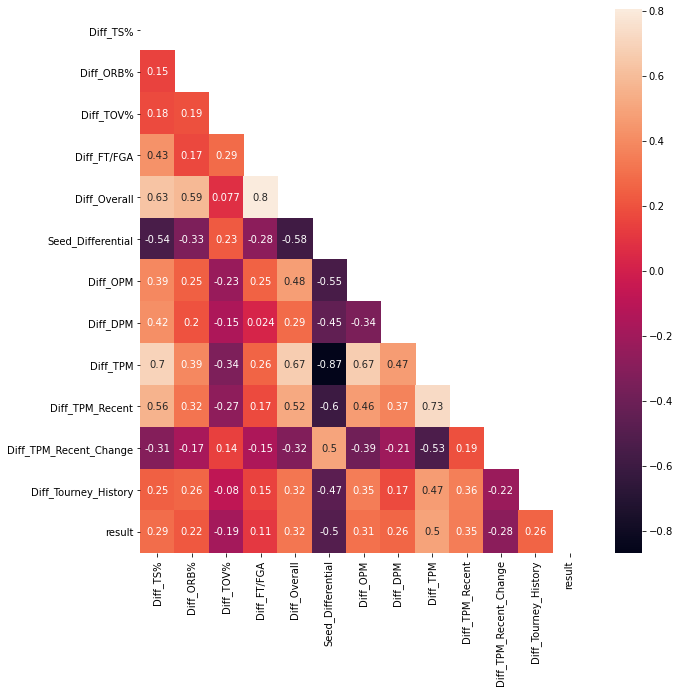

In [50]:
matrix = np.triu(explore_df.corr())
fig, ax = plt.subplots(figsize=(10,10))
plot = sns.heatmap(explore_df.corr(), annot = True, mask=matrix, ax=ax)

It does look like Diff TPM and Seed Differential correlate extremely strongly. We may not get much benefit if any from including both in our model but we will keep them included for now.

Since we have so many features, we will create three different plots to take a look at the interactions. We will plot the advance statistics together, the point margin features together, and then a third to plot what I expect to be most important features from each group to see any interactions between the groups of features.

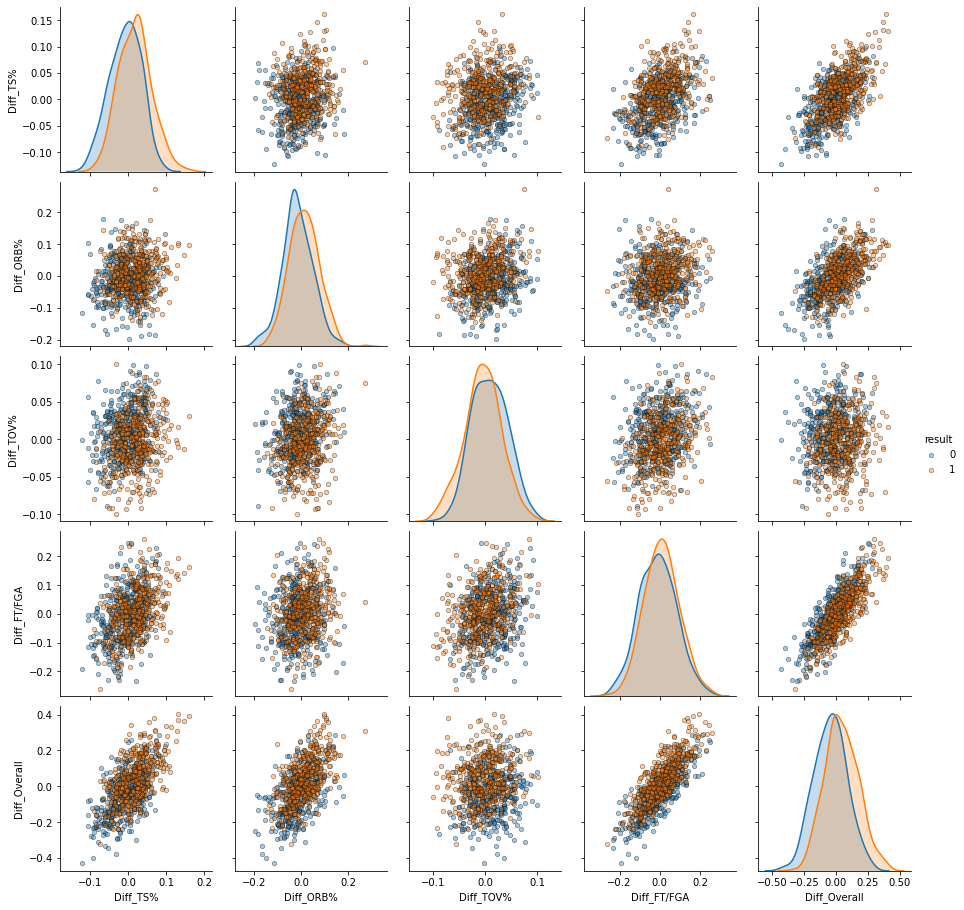

In [51]:
plot = sns.pairplot(explore_df, hue="result", vars=feature_list_advanced_stats, plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})

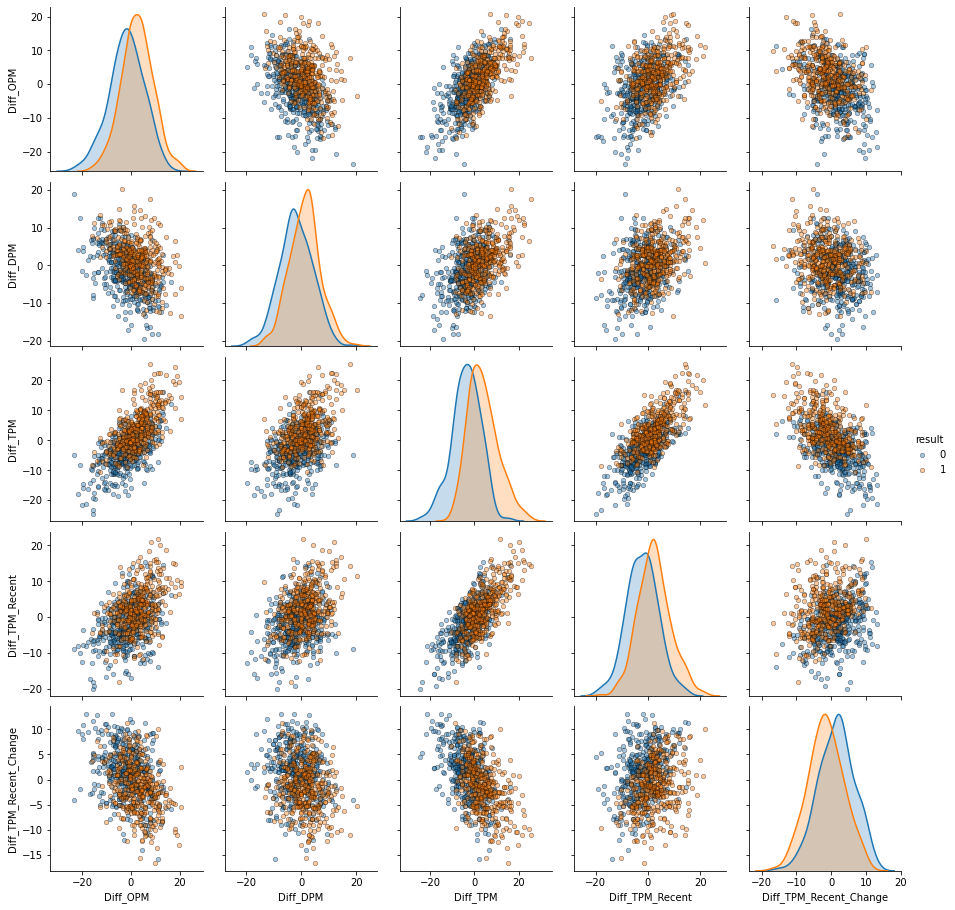

In [52]:
plot = sns.pairplot(explore_df, hue="result", vars=feature_list_point_margins, plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})

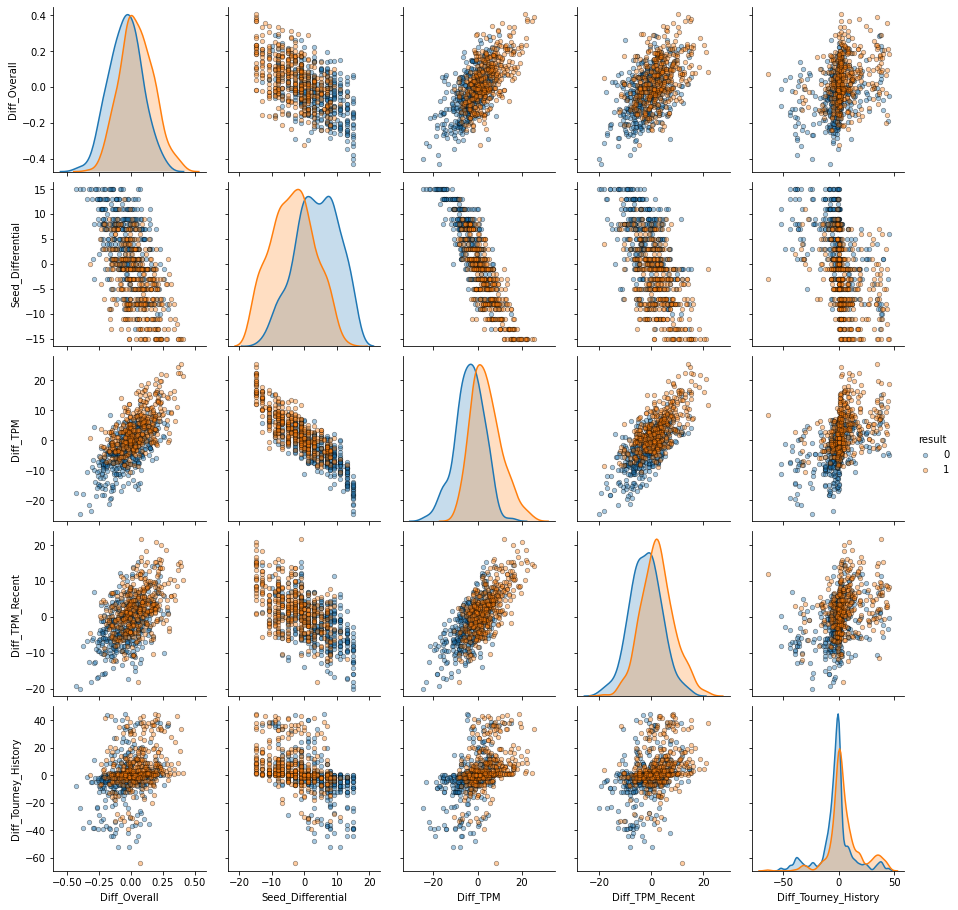

In [53]:
plot = sns.pairplot(explore_df, hue="result", vars=feature_list_primary_features, plot_kws = {'alpha': 0.4, 's': 20, 'edgecolor': 'k'})

We can see that Seed Differential and Diff_TPM seem to have an interaction together and are highly correlated as we noted earlier. That makes sense because a team's seed will be very closely correlated with their overall performance over the season with respect to the teams they played.

## Split into Training/Testing

In [54]:
x = TourneyCompactResults_Train.loc[:, feature_list]
xs = pd.DataFrame(preprocessing.StandardScaler().fit_transform(x), columns = x.columns)
y = TourneyCompactResults_Train[['result']]
x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, stratify = TourneyCompactResults_Train['Season'])

## Building a Model

First, lets include all features and hypertune for $\alpha$ again to see what will work well for this model.

In [55]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train.loc[:, feature_list], y_train.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.6236141223690356
0.01 -0.5594538519096692
0.1 -0.552859040686168
1 -0.5548585948860876
10 -0.555227517800408
100 -0.5552675626395935
1000 -0.5552715766257549


We note that $\alpha=.1$ is now the best $\alpha$ for this model. Now we can create a logistic regression model using $\alpha=C=.1$

In [56]:
lr = LogisticRegression(solver='lbfgs',C=.1,random_state=42,max_iter=500)
model = lr.fit(x_train.loc[:, feature_list], y_train.values.ravel())
ypred = model.predict_proba(x_test.loc[:, feature_list])
score = log_loss(y_test, ypred[:,1])
score

0.5419035126737995

Now lets check the primary features only and see how that preforms, again hypertuning for $\alpha$.

In [57]:
for alpha in [0.001,0.01,0.1,1,10,100,1000]:
    
    lr = LogisticRegression(solver='lbfgs',C=alpha,random_state=42,max_iter=500)
    score = cross_val_score(lr, x_train.loc[:, feature_list_primary_features], y_train.values.ravel(), cv=5, scoring='neg_log_loss')
    print(alpha, np.mean(score))

0.001 -0.6409024339937809
0.01 -0.5696267330573919
0.1 -0.5502046696687238
1 -0.5497170292783107
10 -0.5500259954393281
100 -0.550067540373057
1000 -0.5500718207570369


$\alpha=1$ is now the best $\alpha$ for this model. Now we can create a logistic regression model using $\alpha=C=.1$

In [58]:
lr = LogisticRegression(solver='lbfgs',C=1,random_state=42,max_iter=500)
model = lr.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
ypred = model.predict_proba(x_test.loc[:, feature_list_primary_features])
score = log_loss(y_test, ypred[:,1])
score

0.5447809433744538

We seem to have gained some accuracy using only the primary feature set. We will use the primary feature set and test to see if we can get any additional accuracy by using a different model.

## Trying other models & stacking

Lets try other models alongside logistic regression. We will try these models and compare:

* Random Forest

* Support Vector Machine

* KNearestNeighbor

* Stochastic Gradient Descent

* XGBoost

* Stacking

We will also do a grid search to find the most optimal parameters for the XGBoostClassifier. For the stacking classifier, we will stack with a randomized grid search for the XGBoost instead of a full grid search due to computation speed.

In [59]:
xgb_params = {'min_child_weight':[4,5]
          ,'gamma':[i/10.0 for i in range(3,6)]
          ,'subsample':[i/10.0 for i in range(6,11)]
          ,'colsample_bytree':[i/10.0 for i in range(6,11)]
          ,'max_depth': [2,3,4]}

In [66]:
rf = RandomForestClassifier(n_estimators=100,random_state=42,min_samples_split=100)
lr = LogisticRegression(solver='lbfgs',C=1,random_state=42,max_iter=500)
lsvc = SVC(random_state=42,probability=True,kernel='linear')
nnb = KNeighborsClassifier(50)
sgd = SGDClassifier(loss = 'log')
xgb =  GridSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('lr',LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)),
    ('nnb',KNeighborsClassifier(50)),
    ('lsvc',SVC(random_state=42,probability=True,kernel='linear')),
    ('xgb', RandomizedSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

model_lr = lr.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_rf = rf.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_lsvc = lsvc.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_nnb = nnb.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_xgb = xgb.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_clf = clf.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
model_sgd = sgd.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())

ypred_lr = model_lr.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_rf = model_rf.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_lsvc = model_lsvc.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_nnb = model_nnb.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_xgb = model_xgb.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_clf = model_clf.predict_proba(x_test.loc[:, feature_list_primary_features])
ypred_sgd = model_sgd.predict_proba(x_test.loc[:, feature_list_primary_features])

score_lr = log_loss(y_test, ypred_lr[:,1])
score_rf = log_loss(y_test, ypred_rf[:,1])
score_lsvc = log_loss(y_test, ypred_lsvc[:,1])
score_nnb = log_loss(y_test, ypred_nnb[:,1])
score_xgb = log_loss(y_test, ypred_xgb[:,1])
score_clf = log_loss(y_test, ypred_clf[:,1])
score_sgd = log_loss(y_test, ypred_sgd[:,1])


print('         Logistic Regression:', score_lr)
print('    Random Forest Classifier:', score_rf)
print('   Support Vector Classifier:', score_lsvc)
print(' KNearestNeighbor Classifier:', score_nnb)
print('          XGBoost Classifier:', score_xgb)
print(' Stochastic Gradient Descent:', score_sgd)
print('         Stacking Classifier:', score_clf)

         Logistic Regression: 0.5021429575706319
    Random Forest Classifier: 0.46618951004268566
   Support Vector Classifier: 0.5057286413055642
 KNearestNeighbor Classifier: 0.5163374751371718
          XGBoost Classifier: 0.2976630379779459
 Stochastic Gradient Descent: 0.5361750949249916
         Stacking Classifier: 0.4388312083320075


We can see we're actually getting excellent performance out of logistic regression but managed to get a small increase with XGBoost. We will consider both of these models moving forward.

# Testing the Models

Now that we have created some models, we can train on the full 2003-2014 dataset and then test again on the 2015-2018 seasons and see how they do. Realistically, we will have access to the 2015 data in 2016, the 2016 data in 2017, and so on. Therefore to make the testing as realistic as possible we need to train on data starting from 2003 and up to the prediction season for training each year.

In [68]:
rf_models = {}
lr_models = {}
xgb_models = {}
scalers = {}

results_final = pd.DataFrame( columns=['Year', 'Logistic Regression', 'XGBoostClassifier', 'Random Forest', 'Support Vector Machine', 'Nearest Neighbor', 'Stacking Classifier', 'Stochastic Gradient Descent'])

for i in range(2017,2021):
    if i == 2020:
        continue
    print(i)
    scaler = preprocessing.StandardScaler()
    
    data = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= i]
    
    scaler.fit(data)
    
    x_train = pd.DataFrame(scaler.transform(data[data['Season'] < i]), columns = data.columns)
    y_train = x_train[['result']].round(0)
    
    x_test = pd.DataFrame(scaler.transform(data[data['Season'] == i]), columns = data.columns)
    y_test = x_test[['result']].round(0)
    
    
    rf = RandomForestClassifier(n_estimators=100,random_state=42,min_samples_split=100)
    lr = LogisticRegression(solver='lbfgs',C=1,random_state=42,max_iter=500)
    lsvc = SVC(random_state=42,probability=True,kernel='linear')
    nnb = KNeighborsClassifier(50)
    sgd = SGDClassifier(loss = 'log')
    xgb =  RandomizedSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params)

    estimators = [
        ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
        ('lr',LogisticRegression(solver='lbfgs',C=0.1,random_state=42,max_iter=500)),
        ('nnb',KNeighborsClassifier(50)),
        ('lsvc',SVC(random_state=42,probability=True,kernel='linear')),
        ('xgb', RandomizedSearchCV(XGBClassifier(eval_metric = 'logloss'), xgb_params))]

    clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

    model_lr = lr.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_rf = rf.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_lsvc = lsvc.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_nnb = nnb.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_xgb = xgb.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_clf = clf.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())
    model_sgd = sgd.fit(x_train.loc[:, feature_list_primary_features], y_train.values.ravel())

    ypred_lr = model_lr.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_rf = model_rf.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_lsvc = model_lsvc.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_nnb = model_nnb.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_xgb = model_xgb.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_clf = model_clf.predict_proba(x_test.loc[:, feature_list_primary_features])
    ypred_sgd = model_sgd.predict_proba(x_test.loc[:, feature_list_primary_features])

    score_lr = log_loss(y_test, ypred_lr[:,1])
    score_rf = log_loss(y_test, ypred_rf[:,1])
    score_lsvc = log_loss(y_test, ypred_lsvc[:,1])
    score_nnb = log_loss(y_test, ypred_nnb[:,1])
    score_xgb = log_loss(y_test, ypred_xgb[:,1])
    score_clf = log_loss(y_test, ypred_clf[:,1])
    score_sgd = log_loss(y_test, ypred_sgd[:,1])
    
    lr_models[i] = model_lr 
    xgb_models[i] = model_xgb 
    rf_models[i] = model_rf
    scalers[i] = scaler
    
    results = pd.DataFrame([[i, score_lr, score_xgb, score_rf, score_lsvc, score_nnb, score_clf, score_sgd]], columns=['Year', 'Logistic Regression', 'XGBoostClassifier', 'Random Forest', 'Support Vector Machine', 'Nearest Neighbor', 'Stacking Classifier', 'Stochastic Gradient Descent'])
    
    results_final = pd.concat([results_final, results], ignore_index=True)
results_final.set_index('Year', inplace=True)

2017
2018
2019


In [69]:
results_transpose = results_final.T
results_transpose['Average Score'] = (results_transpose[2017] + results_transpose[2018] + results_transpose[2019])/3
# results_transpose['Average Score'] = (results_transpose[2015] + results_transpose[2016] + results_transpose[2017] + results_transpose[2018] + results_transpose[2019])/5
results_transpose.sort_values('Average Score')

Year,2017,2018,2019,Average Score
Logistic Regression,0.511385,0.605235,0.503770,0.540130
Support Vector Machine,0.515544,0.601646,0.508574,0.541921
Stacking Classifier,0.528250,0.607109,0.529230,0.554863
Random Forest,0.532206,0.628715,0.520712,0.560545
Stochastic Gradient Descent,0.538579,0.663871,0.547798,0.583416
XGBoostClassifier,0.601479,0.746658,0.676610,0.674916
Nearest Neighbor,0.541318,1.094668,0.530928,0.722305


Interestingly, even though the Random Forest did well during training, logistic regression clearly performs the best in a realistic testing environment, indicating some models may have overfit on the training data. Logistic regression seems to perform the best, and this does make mathematical sense as logistic regression minimizes for log loss and therefore is optimal for our scoring method.

# Simulating the 2020 Tournament

Due to the COVID-19 pandemic, the NCAA tournament for 2020 never got to be played. Cancellation of the NCAA tournament is completely unprecendented and I definitely hope it never has to happen again. To make up for it, I wanted to see what a simulation of the 2020 Tournament would look like. 

Unfortunately, we are starting with a big problem right off the bat; the NCAA never released official seedings for the 2020 NCAA tournament. Therefore we will need to use expert opinion to create the seedings ourselves. To this end we will go with Joe Lunardi's bracket from ESPN which can be found here: http://www.espn.com/mens-college-basketball/bracketology/_/iteration/257

## Building the Simulation

First, we need to create the simulation mechanism.

In [71]:
ncaa_order = [c+'{:02d}'.format(i) for c in ['W','X','Y','Z'] for i in [1,16,8,9,5,12,4,13,6,11,3,14,7,10,2,15]]
ncaa_order_dict = dict(zip(ncaa_order,range(64)))

In [75]:
TourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'])
TourneySeeds                        

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2349,2021,Z12,1457
2350,2021,Z13,1317
2351,2021,Z14,1159
2352,2021,Z15,1331


In [76]:
# TourneySeeds = pd.concat([pd.DataFrame(data_frames['MNCAATourneySeeds'].copy()), pd.DataFrame(data_frames['TournamentSeeds2020'].copy())], ignore_index=True)
TourneySeeds = pd.DataFrame(data_frames['MNCAATourneySeeds'])
# TourneySeeds = TourneySeeds[TourneySeeds['Season'] >= 2019][TourneySeeds['Season'] <= 2020]
TourneySeeds = TourneySeeds[TourneySeeds['Season'] == 2021]
TourneySeeds['SeedN'] = TourneySeeds['Seed'].apply(lambda x: int(x[1:3]))
TourneySeeds['TourneyOrder'] = TourneySeeds['Seed'].apply(lambda x: str(x[0:3]))
TourneySeeds = TourneySeeds.replace({"TourneyOrder": ncaa_order_dict})
TourneySeeds['TourneyOrder'] = TourneySeeds['TourneyOrder'].astype('int')
TourneySeeds.sort_values('TourneyOrder', inplace=True)

We can see we now have the 2020 seeds loaded from the TournamentSeeds2020 file and a couple helper columns for ordering the dataframe for simulation purposes. We are ordering the seeding to match the ordering in the bracket;  1 vs 16, 8 vs 9, 5 vs 12, 4 vs 13, 6 vs 11, 3 vs 14, 7 vs 10, and finally 2 vs 15. Since we are ordering in the same order as the bracket, when we calculate the winner of the first game and the second game, we do not need reorder the dataset again as the teams playing in every game will appear in the order that they will play which will make the simulation easier to do.

We noted earlier that its possible for any team to play in any other team in the tournament. To make sure the simulation runs efficiently, we will create a table with all of the probabilities for every possible matchup beforehand so that we do not need to calculate it on the fly during the simulation. We simply need to create a dataframe of all possible matchups and run our model on it as we have done previously.

In [77]:
matchup_list = []

for season in pd.unique(TourneySeeds['Season']):
    for team in pd.unique(TourneySeeds['TeamID'][TourneySeeds['Season'] == season]):
        for team2 in pd.unique(TourneySeeds['TeamID'][TourneySeeds['Season'] == season]):
            if team != team2:
                
                Matchup_Id = str(season) + '_' + str(team) + '_' + str(team2)
                
                matchup_list.append([Matchup_Id, season, team, team2])
                
matchup_df = pd.DataFrame(matchup_list, columns=['ID', 'Season', 'TeamID1', 'TeamID2'])

In [78]:
matchup_df = (matchup_df
         .merge(seasonAve
                ,left_on=['Season','TeamID1']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(seasonAve
                ,left_on=['Season','TeamID2']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(season_margin_Ave
                ,left_on=['Season','TeamID1']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(season_margin_Ave
                ,left_on=['Season','TeamID2']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(TourneySeeds
                ,left_on=['Season','TeamID1']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(TourneySeeds
                ,left_on=['Season','TeamID2']
                ,right_on=['Season','TeamID'],how='left')
         .drop('TeamID',axis=1)
         .merge(historical_tourney_performance
                , left_on=['Season','TeamID1']
                ,right_on=['Season','WTeamID'],how='left')
         .drop('WTeamID',axis=1)
         .merge(historical_tourney_performance
                , left_on=['Season','TeamID2']
                ,right_on=['Season','WTeamID'],how='left')
         .drop('WTeamID',axis=1)
         .fillna(0)
         )
matchup_df = matchup_df.set_index('ID')
matchup_df['Diff_TS%'] = matchup_df['TS%Diff_x'] - matchup_df['TS%Diff_y'] 
matchup_df['Diff_ORB%'] = matchup_df['ORB%Diff_x'] - matchup_df['ORB%Diff_y'] 
matchup_df['Diff_FT/FGA'] = matchup_df['FT/FGADiff_x'] - matchup_df['FT/FGADiff_y'] 
matchup_df['Diff_TOV%'] = (matchup_df['TOV%Diff_x'] - matchup_df['TOV%Diff_y'])/100
matchup_df['Diff_Overall'] = matchup_df['Diff_TS%'] + matchup_df['Diff_ORB%'] + matchup_df['Diff_FT/FGA'] - matchup_df['Diff_TOV%'] 
matchup_df['Diff_OPM'] = matchup_df['Offensive_Margin_x'] - matchup_df['Offensive_Margin_y']
matchup_df['Diff_DPM'] = matchup_df['Defensive_Margin_x'] - matchup_df['Defensive_Margin_y']
matchup_df['Diff_TPM'] = matchup_df['Total_Margin_x'] - matchup_df['Total_Margin_y']
matchup_df['Diff_TPM_Recent'] = matchup_df['Total_Margin_Recent_x'] - matchup_df['Total_Margin_Recent_y']
matchup_df['Diff_TPM_Recent_Change']  = matchup_df['Total_Margin_Recent_Change_x'] - matchup_df['Total_Margin_Recent_Change_y']
matchup_df['Seed_Differential'] = matchup_df['SeedN_x'] - matchup_df['SeedN_y']
matchup_df['Diff_Tourney_History']  = matchup_df['Round_Win_Weighting_x'] - matchup_df['Round_Win_Weighting_y']
matchup_df[feature_list_primary_features].head()

,Diff_Overall,Seed_Differential,Diff_TPM,Diff_TPM_Recent,Diff_Tourney_History
ID,,,,,
2021_1276_1291,0.100876,-15,12.178933,6.954120,0.0
2021_1276_1411,0.114137,-15,12.483119,4.626680,0.0
2021_1276_1261,0.112475,-7,2.732135,-0.736860,0.0
2021_1276_1382,0.062457,-8,1.357677,-6.247188,0.0
2021_1276_1160,0.026133,-4,2.045752,3.252884,0.0


We now have a dataframe with a row for every possible matchup and the features we need to make predictions.

In [79]:
scaler = preprocessing.StandardScaler()
data = TourneyCompactResults[TourneyCompactResults['Season'] >= 2003][TourneyCompactResults['Season'] <= season]
scaler.fit(data.loc[:,feature_list_primary_features])

matchup_df_s = pd.DataFrame(scaler.transform(matchup_df.loc[:,feature_list_primary_features]), columns = feature_list_primary_features)

matchup_pred = lr_models[2019].predict_proba(matchup_df_s.loc[:, feature_list_primary_features])

matchup_df['pred'] = matchup_pred[:,1]

In [80]:
probabilities_df = matchup_df['pred'] 
probabilities_df

ID
2021_1276_1291    0.921855
2021_1276_1411    0.925400
2021_1276_1261    0.667545
2021_1276_1382    0.660710
2021_1276_1160    0.606060
                    ...   
2021_1331_1116    0.084294
2021_1331_1159    0.142390
2021_1331_1196    0.193551
2021_1331_1439    0.236748
2021_1331_1326    0.113577
Name: pred, Length: 4556, dtype: float64

Now that we have the probabilities, we can run the simulation. We already have a list of every team and the order that they will play in the tournament. We will need to handle the play in games as a special case but we can identify them by the given "seed" having a length of 4. We will use this to identify play in games and simulate them in round 0. We will create a function to loop through this list and produce all the matchups by picking the teams using the order we set.

In [81]:
def create_matchups(df):
    matchups = []
#     print(round(len(df)/2,0))
    for matchup in range(0,int(len(df)/2)):

        Season = str(df['Season'][matchup * 2])
        TeamID1 = str(df['TeamID'][matchup * 2])
        TeamID2 = str(df['TeamID'][matchup * 2 + 1])

        SeedTeam1 = str(df['SeedN'][matchup * 2])
        SeedTeam2 = str(df['SeedN'][matchup * 2 + 1])
        
        IndexTeam1 = str(df['index'][matchup * 2])
        IndexTeam2 = str(df['index'][matchup * 2 + 1])

        matchup_id = Season + '_' + TeamID1 + '_' + TeamID2
        matchups.append([matchup_id, Season, TeamID1, TeamID2, SeedTeam1, SeedTeam2, IndexTeam1, IndexTeam2])

    matchups = pd.DataFrame(matchups, columns = ['ID', 'Season', 'TeamID1', 'TeamID2', 'SeedTeam1', 'SeedTeam2', 'IndexTeam1', 'IndexTeam2'])

    matchups['Season'] = matchups['Season'].astype('int')
    matchups['TeamID1'] = matchups['TeamID1'].astype('int')
    matchups['TeamID2'] = matchups['TeamID2'].astype('int')
    matchups['SeedTeam1'] = matchups['SeedTeam1'].astype('int')
    matchups['SeedTeam2'] = matchups['SeedTeam2'].astype('int')
    matchups['IndexTeam1'] = matchups['IndexTeam1'].astype('int')
    matchups['IndexTeam2'] = matchups['IndexTeam2'].astype('int')
    matchups = matchups.set_index('ID')
    return matchups

In order to actually simulate the result, we just need to compare the prediction value of Team 1, $p_{1}$, to $y = \mbox{Uniform}(0,1)$. Then,
\begin{equation*}
f(x) = 
 \begin{cases} 
      \mbox{Team 1 win} & p_1 \le y \\
      \mbox{Team 2 win} & p_1 > y
   \end{cases}
\end{equation*}

In [82]:
def simulate_result(df):
    df = (df
          .merge(probabilities_df, right_index=True, left_index=True)
         )
    df['Outcome'] = np.random.uniform(0,1, len(df))
    df.loc[df['Outcome'] <= df['pred'], 'result'] = 1 
    df.loc[df['Outcome'] > df['pred'], 'result'] = 0
    
    df.loc[df['result'] == 1, 'WTeamID'] = df.loc[df['result'] == 1, 'TeamID1']
    df.loc[df['result'] == 0, 'WTeamID'] = df.loc[df['result'] == 0, 'TeamID2']
    
    df.loc[df['result'] == 1, 'LTeamID'] = df.loc[df['result'] == 1, 'TeamID2']
    df.loc[df['result'] == 0, 'LTeamID'] = df.loc[df['result'] == 0, 'TeamID1']
    
    return(df)

We can now use this function to simulate a round. We just need to tie this together into a final simulation function. We will allow the function to accept a parameter for both season and the number of simulations.

In [83]:
def simulation(simulation_year, simulations):
    
    df_results = pd.DataFrame()
    
    TourneyTeams = TourneySeeds.loc[TourneySeeds['Season'] == simulation_year]

    for simulation in range(0,simulations):

        PlayInGames = TourneyTeams[TourneyTeams['Seed'].apply(lambda x: len(x)==4)]
        PlayInGames.reset_index(inplace=True)

        playin_matchups = create_matchups(PlayInGames)
        playin_matchups_result = simulate_result(playin_matchups)

        first_round_loss = TourneyTeams[TourneyTeams['TeamID'].isin(playin_matchups_result['LTeamID'])]
        remaining_teams = TourneyTeams[~TourneyTeams['TeamID'].isin(playin_matchups_result['LTeamID'])]

        first_round_loss['Round'] = 'Round 0'
        df_results = pd.concat([df_results, first_round_loss], ignore_index=True)

        for round in range(1,7):

            remaining_teams.reset_index(inplace=True)
            matchups = create_matchups(remaining_teams)
            matchups_result = simulate_result(matchups)

            round_loss = TourneyTeams[TourneyTeams['TeamID'].isin(matchups_result['LTeamID'])]
            round_loss['Round'] = 'Round ' + str(round)
            remaining_teams = TourneyTeams[TourneyTeams['TeamID'].isin(matchups_result['WTeamID'])]
            df_results = pd.concat([df_results, round_loss], ignore_index=True)

            if round == 6:

                remaining_teams['Round'] = 'Round ' + str(round + 1)
                df_results = pd.concat([df_results, remaining_teams], ignore_index=True)
    
    return df_results

## Running the Simulation

Now we can easily run a simulation for 2019 and 2020 and run both 10000 times.

In [84]:
# results_2019 = simulation(2019,10000)
# results_2020 = simulation(2020,10000)
results_2020 = simulation(2021,10000)

We can now view the results and compare with 2019. We will create a function for coding simplicity and also add in the team names.

In [85]:
Team_Names = pd.DataFrame(data_frames['MTeams'].copy()).drop('FirstD1Season', axis=1).drop('LastD1Season', axis=1)

In [86]:
def show_final_result(df):
    df_results = df.merge(Team_Names, on=['TeamID'], how='left')
    df_results['Probability'] = 1
    final_df = (df_results.loc[:,['TeamName', 'Round', 'Probability']].groupby(['TeamName', 'Round']).sum()[::-1].unstack('Round')).fillna(0)
    final_probs = final_df.div(final_df.sum(axis=1), axis=0)*100
    final_cumsum = final_probs[final_probs.columns[::-1]].cumsum(axis=1)
    final_cumsum = final_cumsum[final_cumsum.columns[::-1]].sort_values(
        [('Probability', 'Round 7'),
        ('Probability', 'Round 6'),
        ('Probability', 'Round 5'),
        ('Probability', 'Round 4'),
        ('Probability', 'Round 3'),
        ('Probability', 'Round 2'),
        ('Probability', 'Round 1'),
        ('Probability', 'Round 0')], ascending=False)

    return final_cumsum

## 2019 Probabilities
Here are the results for 2019. Note: "Round 7" is the probability of winning the entire tournament. 

In [205]:
# show_final_result(results_2019).drop([('Appearances', 'Round 0')], axis=1).to_csv('Results_2019.csv')
show_final_result(results_2019).drop([('Probability', 'Round 0')], axis=1)

Probability                                                
Round              Round 1 Round 2 Round 3 Round 4 Round 5 Round 6 Round 7
TeamName                                                                  
Gonzaga             100.00   98.52   90.85   79.78   63.91   45.76   33.09
Duke                100.00   98.45   84.10   67.14   50.33   26.08   16.39
Virginia            100.00   97.08   85.15   69.10   48.11   30.69   14.89
North Carolina      100.00   96.89   79.65   59.33   39.93   23.78   11.10
Tennessee           100.00   90.78   68.09   45.15   21.91   11.28    3.79
Michigan St         100.00   94.20   70.77   52.50   23.36    8.24    3.60
Houston             100.00   90.71   67.39   40.44   20.30    9.38    3.42
Kentucky            100.00   89.80   63.02   34.36   15.99    6.87    2.17
Texas Tech          100.00   86.20   56.47   30.60    9.74    4.14    1.83
Michigan            100.00   87.13   57.05   32.67   10.39    4.49    1.80
Purdue              100.00   85.54   55.98   26.89   11.07    4.90    1.40
Virginia Tech       100.00   85.70   58.68   18.44    8.91    2.42    0.85
Auburn              100.00   71.34   42.72   16.43    7.48    2.88    0.82
Nevada              100.00   71.41   32.52   16.47    4.41    1.71    0.60
Buffalo             100.00   77.79   35.80   16.29    4.39    1.61    0.54
Kansas              100.00   77.83   41.42   13.93    5.31    1.68    0.49
Wisconsin           100.00   66.30   41.97   12.90    5.31    1.78    0.46
Florida St          100.00   74.78   44.74    8.52    3.42    1.08    0.38
LSU                 100.00   78.45   51.13   19.61    6.04    1.36    0.32
Marquette           100.00   61.40   32.25    5.95    2.13    0.73    0.28
Louisville          100.00   76.68   24.76   13.74    3.82    0.85    0.27
Villanova           100.00   58.15   26.09   10.24    3.58    1.13    0.26
Wofford             100.00   71.39   28.62   12.07    4.24    1.24    0.22
Iowa St             100.00   67.94   23.86    9.67    3.32    0.97    0.19
Cincinnati          100.00   65.95   22.74   10.25    3.13    1.01    0.18
Mississippi St      100.00   71.71   31.23    7.07    2.68    0.54    0.16
Kansas St           100.00   71.32   35.32    8.96    3.00    0.93    0.11
Utah St             100.00   58.34   12.85    5.26    1.77    0.47    0.11
Maryland            100.00   61.32   27.71    8.81    1.95    0.25    0.06
VCU                 100.00   57.30    9.85    4.45    1.58    0.23    0.04
St Mary's CA        100.00   41.85   14.54    4.42    1.11    0.33    0.03
Mississippi         100.00   50.16    7.39    2.81    0.79    0.12    0.03
Oklahoma            100.00   49.84    6.90    2.32    0.54    0.11    0.02
Syracuse            100.00   54.65    5.19    2.03    0.45    0.09    0.02
Yale                100.00   21.55    7.44    1.27    0.14    0.03    0.02
Murray St           100.00   38.60   15.32    1.87    0.32    0.10    0.01
UCF                 100.00   42.70    5.95    1.89    0.49    0.09    0.01
Baylor              100.00   45.35    3.74    1.28    0.37    0.08    0.01
UC Irvine           100.00   28.68    7.82    1.10    0.18    0.03    0.01
Liberty             100.00   28.29    6.72    0.61    0.12    0.01    0.01
Montana             100.00   12.87    2.92    0.46    0.04    0.01    0.01
Oregon              100.00   33.70   14.89    2.71    0.69    0.11    0.00
New Mexico St       100.00   28.66   10.52    2.18    0.50    0.11    0.00
Ohio St             100.00   32.06    6.35    1.41    0.29    0.06    0.00
Iowa                100.00   34.05    6.99    2.12    0.43    0.05    0.00
Belmont              65.50   28.39   11.07    2.53    0.32    0.05    0.00
Washington          100.00   41.66    7.21    2.24    0.50    0.04    0.00
Minnesota           100.00   23.32    3.53    1.02    0.13    0.02    0.00
Florida             100.00   28.59    7.51    2.12    0.27    0.01    0.00
Seton Hall          100.00   28.61    6.20    1.40    0.17    0.01    0.00
Northeastern        100.00   22.17    5.

In 2019, Gonzaga was looking like a big favorite coming into the tournament. However, that isn't going to stop March Madness from being March Madness. Virginia was the eventual champion and Texas Tech was their opponent in the championship.

## 2020 Probabilities

Finally, we can take a look at what 2020 might have looked like.

In [87]:
# show_final_result(results_2020).drop([('Appearances', 'Round 0')], axis=1).to_csv('Results_2020.csv')
show_final_result(results_2020).drop([('Probability', 'Round 0')], axis=1)

Probability                                                
Round                Round 1 Round 2 Round 3 Round 4 Round 5 Round 6 Round 7
TeamName                                                                    
Gonzaga               100.00   97.21   87.49   73.04   58.42   46.38   31.40
Baylor                100.00   95.76   80.08   65.83   48.71   32.35   19.31
Houston               100.00   93.78   82.39   62.65   44.76   26.81   15.01
Alabama               100.00   86.02   65.56   44.33   27.39   10.85    4.53
Illinois              100.00   91.87   61.39   41.73   19.83    9.68    4.33
Iowa                  100.00   83.16   61.81   42.07   15.99    9.11    3.90
Michigan              100.00   92.20   60.99   39.35   22.55    8.88    3.60
Arkansas              100.00   62.52   40.68   25.39   12.21    6.05    2.59
Ohio St               100.00   87.65   60.86   31.70   12.57    4.93    1.75
San Diego St          100.00   72.58   45.20   16.49    9.10    3.65    1.39
BYU                   100.00   77.69   43.87   20.56   10.07    3.11    1.01
Virginia              100.00   74.91   46.50   12.28    5.75    2.81    0.85
Colorado              100.00   78.72   43.34   19.94    8.92    2.59    0.82
Florida St            100.00   72.82   42.24   19.49    8.77    2.47    0.82
Tennessee             100.00   81.46   50.28   22.63    7.57    2.49    0.81
Kansas                100.00   75.32   41.64   18.50    5.29    2.45    0.79
USC                   100.00   67.69   39.59   18.04    5.24    2.44    0.79
West Virginia         100.00   79.91   40.37   12.71    5.75    2.04    0.79
Texas                 100.00   62.12   34.22   14.98    7.50    2.31    0.70
Loyola-Chicago        100.00   66.38   27.85   15.68    5.34    1.97    0.67
Texas Tech            100.00   63.02   28.33   15.77    6.29    2.55    0.65
Creighton             100.00   63.73   32.49    7.27    3.05    1.29    0.44
Villanova             100.00   57.63   33.66    9.74    4.25    1.16    0.33
Oklahoma St           100.00   66.15   33.65   12.84    3.62    1.00    0.33
Colgate               100.00   37.48   19.12    9.59    3.54    1.14    0.29
St Bonaventure        100.00   51.67   19.56    9.71    4.08    1.01    0.27
LSU                   100.00   48.33   18.34    8.21    3.09    0.81    0.27
Connecticut           100.00   64.14   21.49    9.91    4.03    0.85    0.19
Purdue                100.00   57.59   28.40    7.40    2.57    0.67    0.18
Florida               100.00   54.71   21.24    7.45    1.81    0.57    0.16
VCU                   100.00   53.24   17.53    7.68    1.53    0.47    0.11
Winthrop              100.00   42.37   21.25    4.93    1.61    0.43    0.10
Wisconsin             100.00   53.00   10.03    4.75    1.65    0.42    0.10
Utah St               100.00   36.98   11.87    4.84    1.40    0.33    0.09
Drake                  65.55   24.03    9.84    3.47    0.72    0.32    0.09
Oregon                100.00   46.76   14.80    6.54    1.24    0.49    0.07
North Carolina        100.00   47.00    9.23    4.01    1.27    0.37    0.07
Virginia Tech         100.00   45.29   14.86    4.89    1.11    0.28    0.06
Clemson               100.00   55.79    9.62    3.52    1.29    0.33    0.04
Oklahoma              100.00   50.45    6.43    2.55    0.88    0.27    0.04
Missouri              100.00   49.55    5.56    2.05    0.62    0.23    0.04
Abilene Chr           100.00   37.88   15.68    5.15    1.84    0.24    0.03
Maryland              100.00   35.86    8.21    2.62    0.63    0.14    0.03
UC Santa Barbara      100.00   36.27   12.46    1.63    0.43    0.12    0.03
Georgia Tech          100.00   33.62    9.35    3.59    0.87    0.20    0.02
Syracuse              100.00   27.42   10.31    1.82    0.55    0.14    0.02
Liberty               100.00   33.85   11.05    2.51    0.47    0.10    0.02
UCLA                   65.66   16.77    5.15    1.21    0.31    0.05    0.02
North Texas           100.00   42.41   16.69    3.28    0.91    0.20    0.01
Rutgers      

Gonzaga still manages to be on top, which is impressive in back to back seasons. However, their lead on other teams has diminished significantly. Dayton is also a surprising name to see in the top of the list but had an extremely good year in 2020, including one of their players earning the player of the year award. 

## 2020 Tournament Simulation

To cap off the project, I wanted to see what might have happened in a single simulation of the 2020 tournament. We can run the simulation like we did before, but just once, and view the results the same.

In [94]:
results_single_2020 = simulation(2021,1)

In [95]:
show_final_result(results_single_2020).drop([('Probability', 'Round 0')], axis=1).head(4) # .to_csv('SingleTourneyRun.csv')

Probability                                                
Round        Round 1 Round 2 Round 3 Round 4 Round 5 Round 6 Round 7
TeamName                                                            
Baylor         100.0   100.0   100.0   100.0   100.0   100.0   100.0
Gonzaga        100.0   100.0   100.0   100.0   100.0   100.0     0.0
Alabama        100.0   100.0   100.0   100.0   100.0     0.0     0.0
Houston        100.0   100.0   100.0   100.0   100.0     0.0     0.0

The above table shows that Dayton won against Baylor to win the Championship. San Diego State and Wisconsin were the other teams in the final four. Below is how the full tournament turned out. Red denotes the loser of the matchup. Green highlights the overall tournament winner.

![First_Half](Single_Run_First_Half.png)

![Second_Half](Single_Run_Second_Half.png)

![Final_Four](Single_Run_Final_Four.png)

And there you have it; what the actual March Madness tournament of 2020 *might* have looked like if it had been able to be played. Some of the big stories of this tournament might have been:

* Creighton losing in the first round to 15th seeded Arkansas Little Rock in an otherwise normal looking South bracket.

* Complete chaos in the Midwest bracket leading to ETSU somehow sneaking into the elite 8 despite being just an 11 seed. 

* Three of the top four most likely teams to win lost much earlier than expected - Duke, Kansas, and Gonzaga. The last remaining team of those top 4 ended up being the winner.

# References

* Lunardi, Joe. “Bracketology with Joe Lunardi.” ESPN, ESPN Internet Ventures, Mar. 2020, www.espn.com/mens-college-basketball/bracketology/_/iteration/257.

* Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

* Norlander, Matt. “NCAA Bracket 2019: Check out How Virginia Was Able to Claim the National Championship.” CBSSports.com, 9 Apr. 2019, www.cbssports.com/college-basketball/news/ncaa-bracket-2019-check-out-how-virginia-was-able-to-claim-the-national-championship/.

* NCAA.com. “Oregon's Sabrina Ionescu, Dayton's Obi Toppin Named 2020 Naismith Players of the Year.” NCAA.com, NCAA.com, 3 Apr. 2020, www.ncaa.com/news/basketball-men/article/2020-04-03/oregons-sabrina-ionescu-daytons-obi-toppin-named-2020.

* NCAA.com. “How the Field of 68 Teams Is Picked for March Madness.” NCAA.com, NCAA.com, 31 Oct. 2019, www.ncaa.com/news/basketball-men/article/2018-10-19/how-field-68-teams-picked-march-madness.


https://www.ncaa.com/news/basketball-men/bracketiq/2018-03-28/longest-ncaa-bracket-has-ever-stayed-perfect